# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# Ising model

The Ising model describes magnetic dipoles in one of two states, either +1 or -1. These spins are arranged in a graph, typically a lattice, where each spin can interact with its neighbouring spins. The total energy of the system in $\alpha_k$ state is the expectation value of the sum of individual potentials:$$E_{\alpha_k} = - J \sum_{\braket{i,j}}s_{i}s_{j},$$where J is called the exchange energy and is a measure of the strength of the spin–spin interaction. The alignment of spins in equilibrium depends on the sign of the exchange energy, J. If J is greater than zero, neighbouring spins tend to align in the lowest energy state. The ground state will be a ferromagnet at low temperatures, with all spins aligned. If J is less than zero, neighbouring spins tend to have opposite alignment in the lowest energy state. The ground state will be an antiferromagnet at low temperatures, with alternating spins.

# Metropolis algorithm:

The algorithm is initialised with a fixed state ($\alpha_j$) of a given temperature and spin configuration and runs until a thermal equilibrium is reached. Continued application produces a statistical fluctuation from which thermodynamic properties can be devised. The method is made up of the following main steps:
1. The algorithm takes the current state $\alpha_j$.
2. Generates a new condition $\alpha_i$, by flipping a random spin in the system.
3. Calculates the energies of the current condition $E_j$ and the new condition $E_i$
    - if $E_j \leq E_i$: The new configuration is accepted as the new state of the system
    - if $E_j > E_i$: The new configuration is accepted as the new state with a probability of $P = \exp(-\Delta E/k_BT)$
4. Return to step 1.

An inherent problem of this method is that because of the 2N possible configurations of the system computing time can be significant.

# The 2D Ising Chain

## Algorithms

In [2]:
def LatticeEnergy(lattice = np.array):
    "A function to calculate the energy of a given lattice state"
    neigbours = generate_binary_structure(2, 1) 
    neigbours[1][1] = False
    spin_energies = -lattice * convolve(lattice, neigbours, mode='constant', cval=0)
    return spin_energies.sum()

def InitialState(N = int, percentage = int):
    "The algorithm creates a 2D spin lattice system with a percentage of how many spins should be up"
    random_values = np.random.random((N,N)) # random values between 0 and 1
    lattice = np.zeros((N, N)) # A grid of zeros
    lattice[random_values>=percentage] = 1 
    lattice[random_values<percentage] = -1
    return lattice

def MetropolisAlgorithm(initial_lattice, N = int, times = int, BJ = float, state_save = "Off"):
    "An algorithm that runs the Metropolis simulation on a spin system"
    # Generating the initial state
    current_lattice = initial_lattice.copy() 
    energy = LatticeEnergy(current_lattice)
    
    # Arrays that contain the total energy and spin of the system at given time steps
    spin_evolution = np.zeros(times-1)
    energy_evolution = np.zeros(times-1)
    state_evolution = [current_lattice.copy()]
    
    for t in range(0,times-1):
        if state_save == "On":
            old_state = current_lattice.copy()
            state_evolution.append(old_state)
        # 2. pick random point on array and flip spin
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = current_lattice[x,y] #initial spin
        spin_j = spin_i*-1 #proposed spin flip
        
        # Compute the change of the system energy
        E_i = 0
        E_j = 0
        if x > 0:
            E_i += -spin_i*current_lattice[x-1,y]
            E_j += -spin_j*current_lattice[x-1,y]
        if x < N-1:
            E_i += -spin_i*current_lattice[x+1,y]
            E_j += -spin_j*current_lattice[x+1,y]
        if y > 0:
            E_i += -spin_i*current_lattice[x,y-1]
            E_j += -spin_j*current_lattice[x,y-1]
        if y < N-1:
            E_i += -spin_i*current_lattice[x,y+1]
            E_j += -spin_j*current_lattice[x,y+1]
        
        # Change the state according to the change of energy
        dE = E_j-E_i
        if (dE > 0)*(np.random.random() < np.exp(-BJ*dE)):
            current_lattice[x,y]=spin_j
            energy += dE
            #state_evolution.append(current_lattice)
        elif dE <= 0:
            current_lattice[x,y]=spin_j
            energy += dE
            #state_evolution.append(current_lattice)
            
        spin_evolution[t] = current_lattice.sum()
        energy_evolution[t] = energy
        #state_evolution.append(current_lattice)
            
    return spin_evolution, energy_evolution , state_evolution

def TemperatureDependance(lattice, BJ_list):
    "A function to calculate the final average spin and energy of a system on different energies"
    # Arrays to contain the data
    spin_means = np.zeros(len(BJ_list))
    E_means = np.zeros(len(BJ_list))
    E_stds = np.zeros(len(BJ_list))
    for i, bj in enumerate(BJ_list):
        spins, energies, states = MetropolisAlgorithm(lattice, 50, 500000, bj)
        spin_means[i] = spins[-100000:].mean()
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
    return spin_means, E_means, E_stds

def M_analytical(BJ):
    "Analytical value of the temperature dependant magnetization of the 2D Ising chain"
    critical_value = 2.269185
    if 1/BJ > critical_value:
        return 0
    elif 1/BJ < critical_value:
        z = np.exp(-2*BJ)
        top = (1+z**2)**(1/4)*(1-6*z**2+z**4)**(1/8)
        bottom = np.sqrt(1-z**2)
        func = top/bottom
        return func

# Simulation

## Single system simulation

In [3]:
# If there is a problem of not being able to run the program try turning off the state_save method of the MetropolisAlgorithm
# as it is quite resource intensive
N = 50
BJ1 = 0.7
BJ2 = 0.2
percentage_1 = 0.75
percentage_2 = 0.25
lattice_1 = InitialState(N, percentage_1)
lattice_2 = InitialState(N, percentage_2)
spins1, energies1, states1 = MetropolisAlgorithm(lattice_1, N, 500000, BJ1, "On")
spins2, energies2, states2 = MetropolisAlgorithm(lattice_1, N, 500000, BJ2, "On")

## Displaying the results

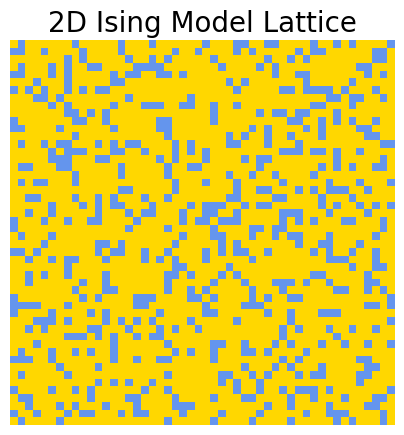

In [4]:
fig = plt.figure(figsize=(14,5))
cmap=ListedColormap(["gold","cornflowerblue"])
plt.imshow(lattice_1, cmap=cmap)
plt.title("2D Ising Model Lattice", size = 20)
plt.axis("off")
plt.savefig("2DIsing_model.jpg", bbox_inches='tight')

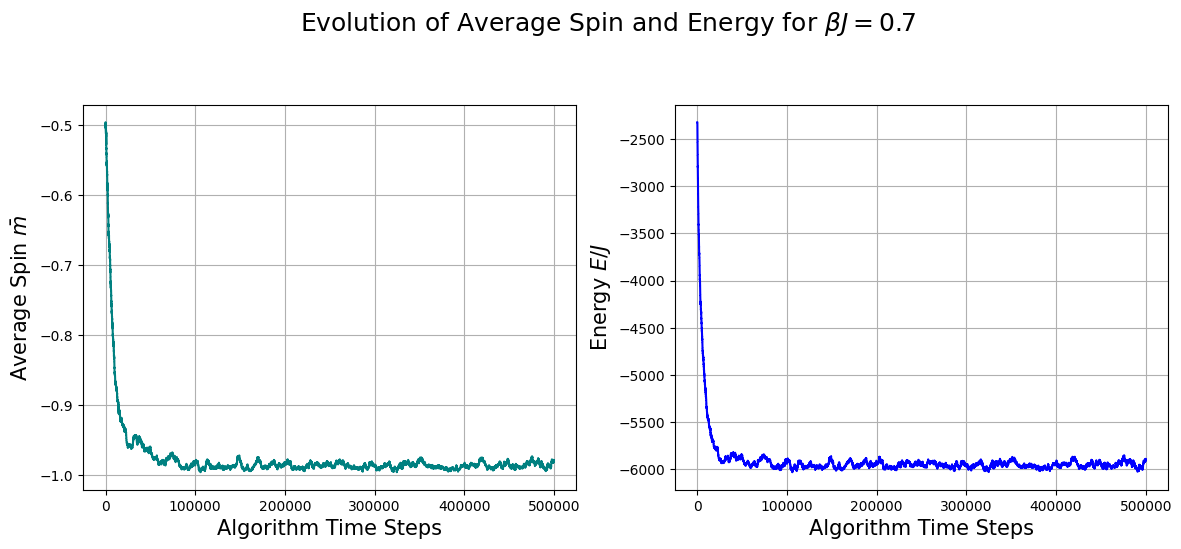

In [5]:
# Plotting the evoultion of spin and energy in the system
fig = plt.figure(figsize=(14,5))
fig.tight_layout()
fig.suptitle(rf'Evolution of Average Spin and Energy for $\beta J=${BJ1}', y=1.07, size=18)
plt.subplot(1, 2, 1)
plt.plot(spins1/N**2, color = "teal")
plt.xlabel('Algorithm Time Steps', size = 15)
plt.ylabel(r'Average Spin $\bar{m}$', size = 15)
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(energies1, color = "blue")
plt.xlabel('Algorithm Time Steps', size = 15)
plt.ylabel(r'Energy $E/J$', size = 15)
plt.grid()
plt.savefig("2DFerro_lowtemp.jpg", bbox_inches='tight')

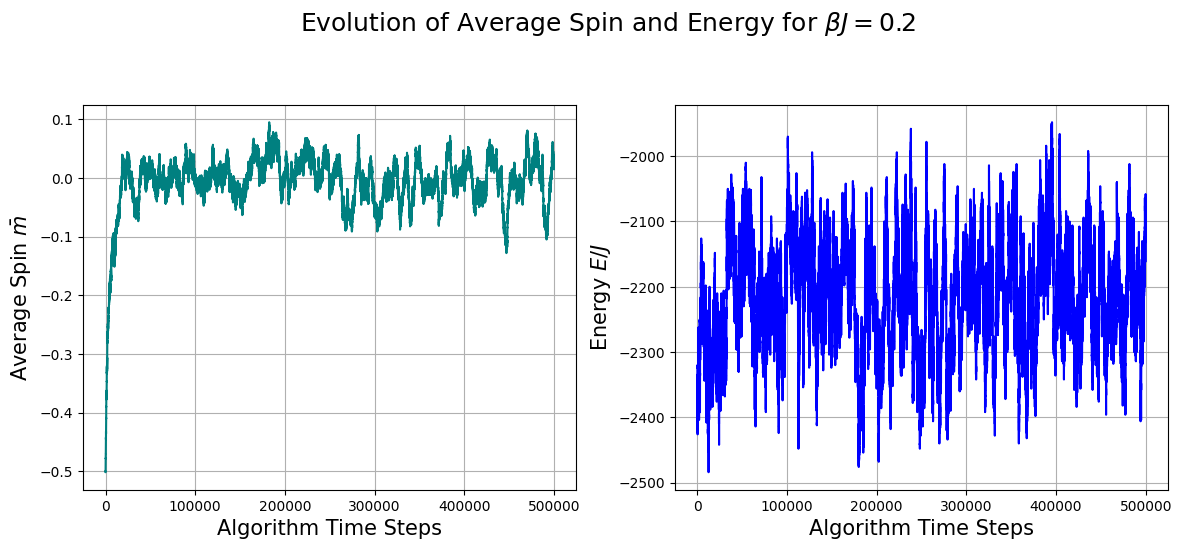

In [6]:
# Plotting the evoultion of spin and energy in the system
fig = plt.figure(figsize=(14,5))
fig.tight_layout()
fig.suptitle(rf'Evolution of Average Spin and Energy for $\beta J=${BJ2}', y=1.07, size=18)
plt.subplot(1, 2, 1)
plt.plot(spins2/N**2, color = "teal")
plt.xlabel('Algorithm Time Steps', size = 15)
plt.ylabel(r'Average Spin $\bar{m}$', size = 15)
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(energies2, color = "blue")
plt.xlabel('Algorithm Time Steps', size = 15)
plt.ylabel(r'Energy $E/J$', size = 15)
plt.grid()
plt.savefig("2DFerro_hightemp.jpg", bbox_inches='tight')

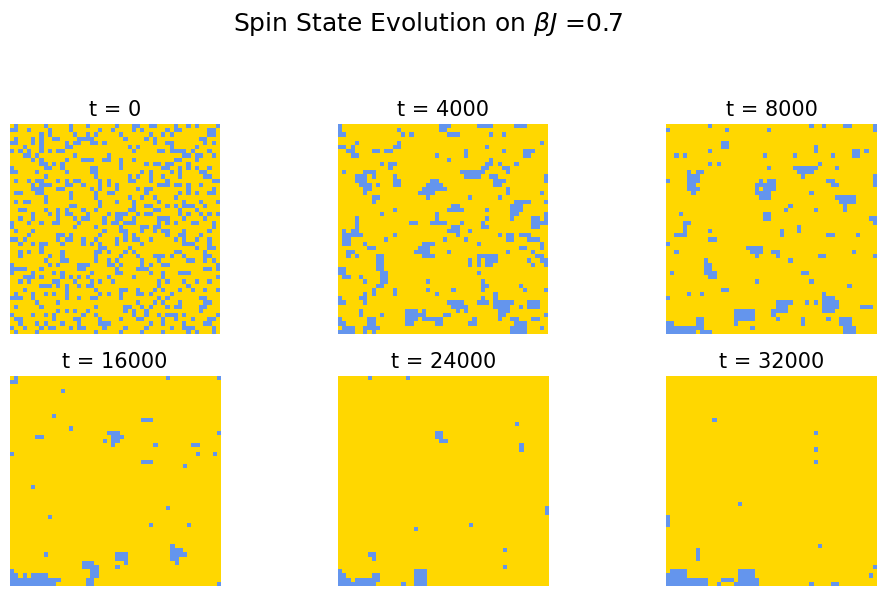

In [7]:
# Plotting configurations of the system at different time steps
displayed_states = [states1[0], states1[4000], states1[8000], states1[16000], states1[24000], states1[32000]]
fig = plt.figure(figsize=(12,6))
fig.tight_layout()
fig.suptitle(rf'Spin State Evolution on $\beta J$ ={BJ1}', y=1.07, size=18)
plt.subplot(2, 3, 1)
plt.imshow(displayed_states[0], cmap=cmap)
plt.title(r"t = 0", size = 15)
plt.axis("off")
plt.subplot(2, 3, 2)
plt.imshow(displayed_states[1], cmap=cmap)
plt.title(r"t = 4000", size = 15)
plt.axis("off")
plt.subplot(2, 3, 3)
plt.imshow(displayed_states[2], cmap=cmap)
plt.title(r"t = 8000", size = 15)
plt.axis("off")
plt.subplot(2, 3, 4)
plt.imshow(displayed_states[3], cmap=cmap)
plt.title(r"t = 16000", size = 15)
plt.axis("off")
plt.subplot(2, 3, 5)
plt.imshow(displayed_states[4], cmap=cmap)
plt.title(r"t = 24000", size = 15)
plt.axis("off")
plt.subplot(2, 3, 6)
plt.imshow(displayed_states[5], cmap=cmap)
plt.title(r"t = 32000", size = 15)
plt.axis("off")
plt.savefig("2DFerro_states.jpg", bbox_inches='tight')

MovieWriter ffmpeg unavailable; using Pillow instead.


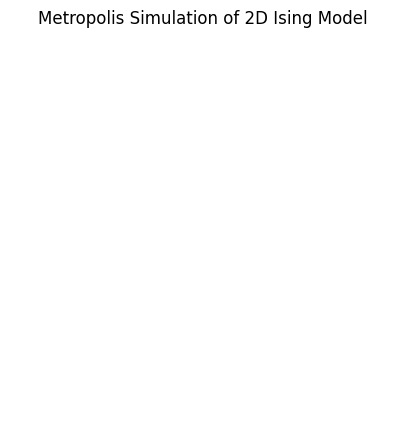

In [8]:
# Animating the system
fig = plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Metropolis Simulation of 2D Ising Model")
ims = []
for i in range(len(states1[0::200])):
    im = plt.imshow(states1[0::200][i], cmap=cmap, rasterized=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200,
    repeat_delay=1000)
ani.save('2DIsing_animation.gif')

## Anti ferro-magnets

In [9]:
BJ3 = -0.7
spins3, energies3, states3 = MetropolisAlgorithm(lattice_1, N, 500000, BJ3, "On")

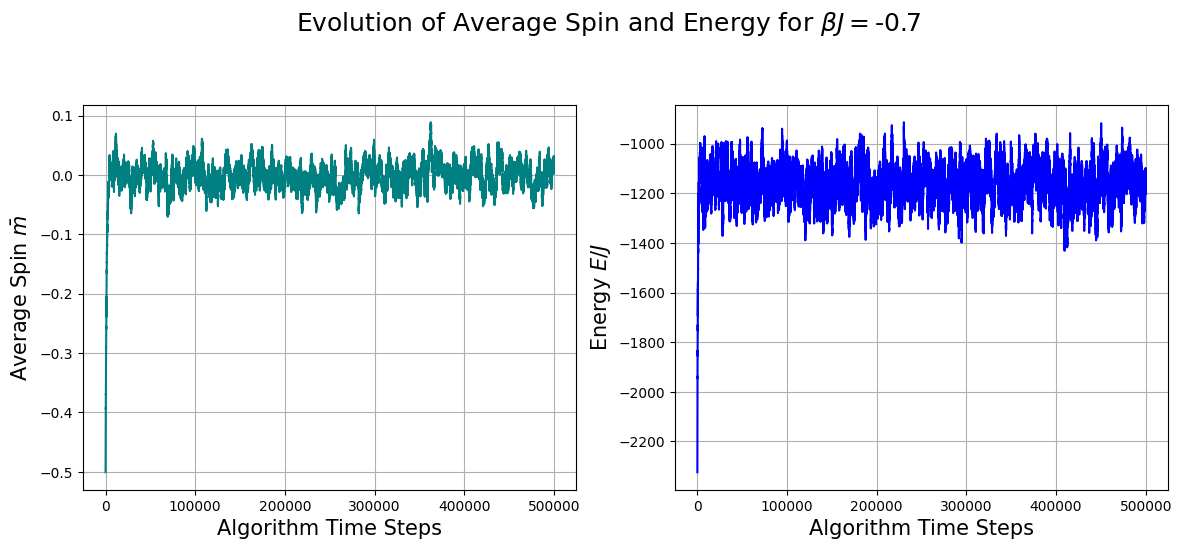

In [10]:
# Plotting the evoultion of spin and energy in the system
fig = plt.figure(figsize=(14,5))
fig.tight_layout()
fig.suptitle(rf'Evolution of Average Spin and Energy for $\beta J=${BJ3}', y=1.07, size=18)
plt.subplot(1, 2, 1)
plt.plot(spins3/N**2, color = "teal")
plt.xlabel('Algorithm Time Steps', size = 15)
plt.ylabel(r'Average Spin $\bar{m}$', size = 15)
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(energies3, color = "blue")
plt.xlabel('Algorithm Time Steps', size = 15)
plt.ylabel(r'Energy $E/J$', size = 15)
plt.grid()
plt.savefig("2DAntiferro_lowtemp.jpg", bbox_inches='tight')

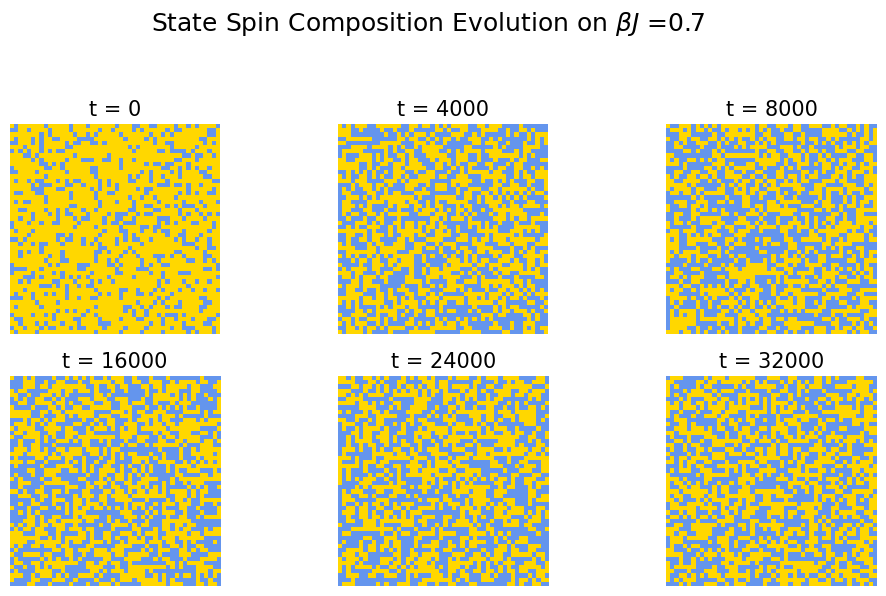

In [11]:
# Plotting configurations of the system at different time steps
displayed_states = [states3[0], states3[4000], states3[8000], states3[16000], states3[24000], states3[32000]]
cmap=ListedColormap(["gold","cornflowerblue"])
fig = plt.figure(figsize=(12,6))
fig.tight_layout()
fig.suptitle(rf'State Spin Composition Evolution on $\beta J$ ={BJ1}', y=1.07, size=18)
plt.subplot(2, 3, 1)
plt.imshow(displayed_states[0], cmap=cmap)
plt.title(r"t = 0", size = 15)
plt.axis("off")
plt.subplot(2, 3, 2)
plt.imshow(displayed_states[1], cmap=cmap)
plt.title(r"t = 4000", size = 15)
plt.axis("off")
plt.subplot(2, 3, 3)
plt.imshow(displayed_states[2], cmap=cmap)
plt.title(r"t = 8000", size = 15)
plt.axis("off")
plt.subplot(2, 3, 4)
plt.imshow(displayed_states[3], cmap=cmap)
plt.title(r"t = 16000", size = 15)
plt.axis("off")
plt.subplot(2, 3, 5)
plt.imshow(displayed_states[4], cmap=cmap)
plt.title(r"t = 24000", size = 15)
plt.axis("off")
plt.subplot(2, 3, 6)
plt.imshow(displayed_states[5], cmap=cmap)
plt.title(r"t = 32000", size = 15)
plt.axis("off")
plt.savefig("2DAntiferro_states.jpg", bbox_inches='tight')

MovieWriter ffmpeg unavailable; using Pillow instead.


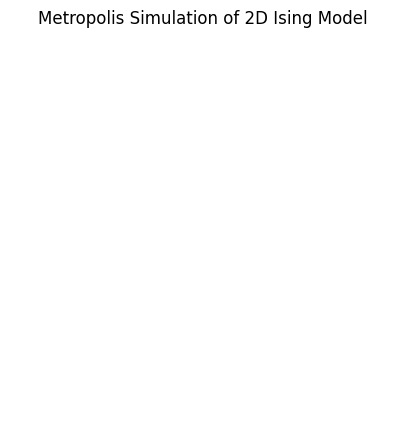

In [12]:
# Animating the system
fig = plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Metropolis Simulation of 2D Ising Model")
ims = []
for i in range(len(states3[0::200])):
    im = plt.imshow(states3[0::200][i], cmap=cmap, rasterized=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200,
    repeat_delay=1000)
ani.save('2DIsingFerro_animation.gif')

## Temperature dependance simulation

In [13]:
BJs = np.arange(0.1, 2, 0.05)
ms_1, E_means_1, E_stds_1 = TemperatureDependance(lattice_1, BJs)
ms_2, E_means_2, E_stds_2 = TemperatureDependance(lattice_2, BJs)

In [14]:
BJ_range = np.linspace(0,2,1000)
M_values = []
for i in BJ_range:
    M_values.append(M_analytical(i))

C:\Users\jmton\AppData\Local\Temp\ipykernel_48688\2038406524.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  if 1/BJ > critical_value:


## Displaing the results

C:\Users\jmton\AppData\Local\Temp\ipykernel_48688\2984618074.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/BJ_range, M_values, "-.", label = "Analytical Magnetization")


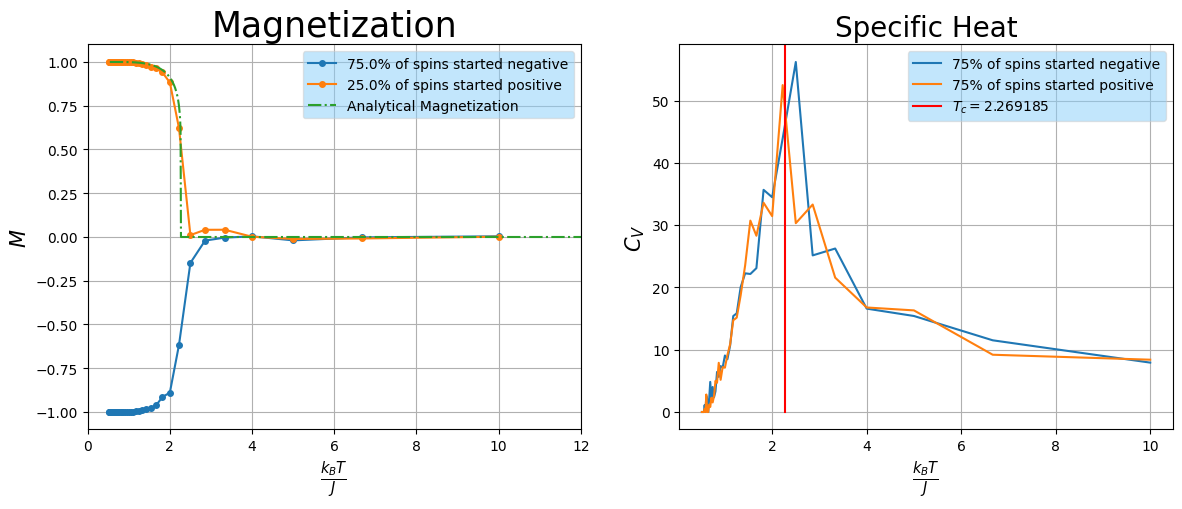

In [15]:
fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(1/BJs, ms_1/N**2, '-', marker = "o", markersize = 4, label=f'{percentage_1*100}% of spins started negative')
plt.plot(1/BJs, ms_2/N**2, '-', marker = "o", markersize = 4, label=f'{percentage_2*100}% of spins started positive')
plt.plot(1/BJ_range, M_values, "-.", label = "Analytical Magnetization")
plt.xlabel(r'$\frac{k_BT}{J}$', size = 15)
plt.ylabel(r'$M$', size = 15)
plt.legend(facecolor='lightskyblue', framealpha=0.5)
plt.title("Magnetization",size = 25)
plt.xlim(0,12)
plt.grid()
plt.subplot(1,2,2)
plt.plot(1/BJs, E_stds_1*BJs, label='75% of spins started negative')
plt.plot(1/BJs, E_stds_2*BJs, label='75% of spins started positive')
plt.xlabel(r'$\frac{k_BT}{J}$', size = 15)
plt.axvline(x = 2.269185, ymin=0.045, color = 'r', label = r'$T_c = 2.269185$')
plt.ylabel(r'$C_V$', size = 15)
plt.title("Specific Heat", size = 20)
plt.grid()
plt.legend(facecolor='lightskyblue', framealpha=0.5)
plt.savefig("2Dferro_tempdep.jpg", bbox_inches='tight')